This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/inverse_magnetization_reconstruction.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/inverse_magnetization_reconstruction/ref/m.dat &> /dev/null

# Inverse Magnetization Reconstruction 
Reconstruct magnetization from stray-field data using physics regularization and L-BFGS optimization. This demo uses a simple Cartesian parameterization of the magnetization vector, with normalization to enforce unit magnitude.

## Setup

In [2]:
from magnumnp import *
import torch
import pathlib

try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

2026-02-24 12:32:12  magnum.np:INFO magnum.np 2.2.0 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmpx7r_13uf.json --HistoryManager.hist_file=:memory:)


## Normalization Helper
Optimize unconstrained 3-component vectors and normalize to the unit sphere.

In [3]:
def normalize_to_unit(m):
    """
    Given unconstrained m of shape (Nx, Ny, Nz, 3), return unit-normalized magnetization.
    """
    return m / m.norm(dim=-1, keepdim=True)

## Simulation Parameters

In [4]:
# Grid
dx, dy, dz = 3e-9, 3e-9, 2.4e-9

# Material
Ms = 1.4e6
A = 1.5e-11
Di = 3e-3
Ku = 1.1e6
Ku_axis = (0, 0, 1)

# Optimization
n_epochs = 50
lr = 1.0
max_iter = 100
history_size = 100

# Regularization weight (balances data fidelity vs. physics energy)
lambda_reg = 5e17

## Load Ground Truth Magnetization (Relaxed micromagnetic state)

In [5]:
mesh, fields = read_vti(this_dir / "data" / "m_true.vti")
m_true = fields["f000"]

## Define simulation domain and material parameters

In [6]:
nx, ny, nz_material = m_true.shape[:3]
nz_vacuum = 30
nz = nz_material + nz_vacuum

mesh = Mesh((nx, ny, nz), (dx, dy, dz))
state = State(mesh)

# Active domain: bottom layer only
domain = state.Constant(False, dtype=torch.bool)
domain[:, :, 0] = True

state.material = {
    "Ms": 1e-20,
    "A": 1e-20,
    "Di": 1e-20,
    "Ku": 1e-20,
    "Ku_axis": torch.tensor(Ku_axis).to(state.device),
}

state.material["A"][domain] = torch.tensor(A)
state.material["Ms"][domain] = torch.tensor(Ms)
state.material["Di"][domain] = torch.tensor(Di)
state.material["Ku"][domain] = torch.tensor(Ku)



2026-02-24 12:32:12  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-24 12:32:12  magnum.np:INFO [Mesh] 100x100x31 (dx= 3e-09 x 3e-09 x 2.4e-09)


## Compute Target H-field from Ground Truth

In [7]:
# Initialize bottom layer with ground truth magnetization
state.m = state.Constant([0.0, 0.0, 0.0])
state.m[:, :, :1, :] = m_true.clone()

# Normal vector for projection
nv = torch.tensor([0.819152, 0, 0.573576])

# Compute demag field from ground truth magnetization at measurement plane (top vacuum layer)
demag_field = DemagField()
h_demag = demag_field.h(state)
h_vec = h_demag[:, :, -1, :]

# Project onto NV axis
h_measurement_target = (h_vec @ nv).unsqueeze(-1).detach()

# Field objects for energy computation
exchange_field = ExchangeField()
dmi_field = InterfaceDMIField()
aniso_field = UniaxialAnisotropyField()

2026-02-24 12:32:16  magnum.np:INFO [DEMAG]: Time calculation of demag kernel = 3.931486129760742 s


## Reconstruction via L-BFGS Optimization (Cartesian Parameterization)

In [8]:
# Initialize with a uniform +z guess 
m_opt = torch.zeros(nx, ny, 1, 3)
m_opt[..., 2] = 1.0

# Save initial guess (m_0)
with torch.no_grad():
    m_0 = normalize_to_unit(m_opt).clone()

m_opt.requires_grad = True

optimizer = torch.optim.LBFGS(
    [m_opt],
    lr=lr,
    max_iter=max_iter,
    history_size=history_size,
    line_search_fn="strong_wolfe",
)

def closure():
    optimizer.zero_grad()

    m_norm = normalize_to_unit(m_opt)

    m_full = state.Constant([0.0, 0.0, 0.0])
    m_full[:, :, :1, :] = m_norm
    state.m = m_full

    # Data fidelity loss
    h_demag_current = demag_field.h(state)
    h_vec_current = h_demag_current[:, :, -1, :]
    h_proj_current = (h_vec_current @ nv).unsqueeze(-1)
    data_loss = torch.nn.functional.l1_loss(h_proj_current, h_measurement_target)

    # Physics energy regularization
    energy = (exchange_field.E(state)
              + dmi_field.E(state)
              + aniso_field.E(state)
              + demag_field.E(state))

    loss = data_loss + lambda_reg * energy

    loss.backward()

    closure.data_loss = data_loss.item()
    closure.energy = energy.item()
    closure.total_loss = loss.item()
    return loss

## Run Optimization Loop

In [9]:
print(f"{'Epoch':>6} | {'Total Loss':>12} | {'Data Loss':>12} | {'Energy':>12} | {'m_diff':>12}")
for epoch in range(1, n_epochs + 1):
    optimizer.step(closure)

    # Snapshot after first optimizer step
    if epoch == 1:
        with torch.no_grad():
            m_rec_1 = normalize_to_unit(m_opt).clone()

    # Compute current reconstruction difference
    with torch.no_grad():
        m_rec_current = normalize_to_unit(m_opt)
        m_diff_current = (m_rec_current[...,0,:] - m_true[...,0,:]).norm(dim=-1).mean().item()

    if epoch == 1 or epoch % 10 == 0:
        print(f"{epoch:6d} | {closure.total_loss:12.4e} | {closure.data_loss:12.4e} | {closure.energy:12.4e} | {m_diff_current:12.4e}")

 Epoch |   Total Loss |    Data Loss |       Energy |       m_diff


     1 |   3.2496e+01 |   2.2805e+01 |   1.9382e-17 |   6.0738e-01


    10 |  -3.9373e+00 |   1.9594e+00 |  -1.1793e-17 |   2.0204e-01


    20 |  -3.9373e+00 |   1.9594e+00 |  -1.1793e-17 |   2.0204e-01


    30 |  -3.9373e+00 |   1.9594e+00 |  -1.1793e-17 |   2.0204e-01


    40 |  -3.9373e+00 |   1.9594e+00 |  -1.1793e-17 |   2.0204e-01


    50 |  -3.9373e+00 |   1.9594e+00 |  -1.1793e-17 |   2.0204e-01


## Evaluate and Save Results

In [10]:
with torch.no_grad():
    m_rec = normalize_to_unit(m_opt)

    m_diff = (m_rec - m_true).norm(dim=-1).mean().item()
    print(f"\nFinal Mean Vector Diff vs Truth: {m_diff:.4f}")

    h_final = (demag_field.h(state)[:, :, -1, :] @ nv).unsqueeze(-1)
    h_err = torch.abs(h_final - h_measurement_target).mean().item()
    print(f"Final H-field MAE: {h_err:.4e}")

    # Compute H-field projections for all magnetization states
    def compute_h_proj(m_slice):
        m_full = state.Constant([0.0, 0.0, 0.0])
        m_full[:, :, :1, :] = m_slice
        state.m = m_full
        h = demag_field.h(state)
        h_proj = (h[:, :, -1, :] @ nv).squeeze(-1)
        return h_proj
    
    h_true = h_measurement_target.squeeze(-1)
    h_0 = compute_h_proj(m_0)
    h_rec_1 = compute_h_proj(m_rec_1)
    h_rec = compute_h_proj(m_rec)

    # Save results
    def save_mag_vti(m_slice, filename):
        # Create a mesh with only the material layer (no vacuum)
        save_mesh = Mesh((nx, ny, 1), (dx, dy, dz))
        save_state = State(save_mesh)
        m_out = save_state.Constant([0.0, 0.0, 0.0])
        m_out[:, :, :, :] = m_slice
        write_vti(m_out, this_dir / "data" / filename)

    save_mag_vti(m_true, "m_true.vti")
    save_mag_vti(m_0, "m_0.vti")
    save_mag_vti(m_rec_1, "m_rec_1.vti")
    save_mag_vti(m_rec, "m_rec.vti")

    torch.save({
        "m_true": m_true,
        "m_0": m_0,
        "m_rec_1": m_rec_1,
        "m_rec": m_rec,
        "h_true": h_true,
        "h_0": h_0,
        "h_rec_1": h_rec_1,
        "h_rec": h_rec,
    }, this_dir / "data" / "results.pt")
    print("Saved results to data/")


Final Mean Vector Diff vs Truth: 0.2020
Final H-field MAE: 1.9594e+00


2026-02-24 12:44:15  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-24 12:44:15  magnum.np:INFO [Mesh] 100x100x1 (dx= 3e-09 x 3e-09 x 2.4e-09)


2026-02-24 12:44:15  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-24 12:44:15  magnum.np:INFO [Mesh] 100x100x1 (dx= 3e-09 x 3e-09 x 2.4e-09)


2026-02-24 12:44:15  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-24 12:44:15  magnum.np:INFO [Mesh] 100x100x1 (dx= 3e-09 x 3e-09 x 2.4e-09)


2026-02-24 12:44:15  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-24 12:44:15  magnum.np:INFO [Mesh] 100x100x1 (dx= 3e-09 x 3e-09 x 2.4e-09)


Saved results to data/


## Plot Results

In [11]:
import torch
import matplotlib.pyplot as plt

data = torch.load("data/results.pt")
m_true = data["m_true"].cpu()
m_0 = data["m_0"].cpu()
m_rec_1 = data["m_rec_1"].cpu()
m_rec = data["m_rec"].cpu()
h_true = data["h_true"].cpu()
h_0 = data["h_0"].cpu()
h_rec_1 = data["h_rec_1"].cpu()
h_rec = data["h_rec"].cpu()

### Magnetization Comparison (Ground Truth / Starting Guess / After 1 Step / Final)

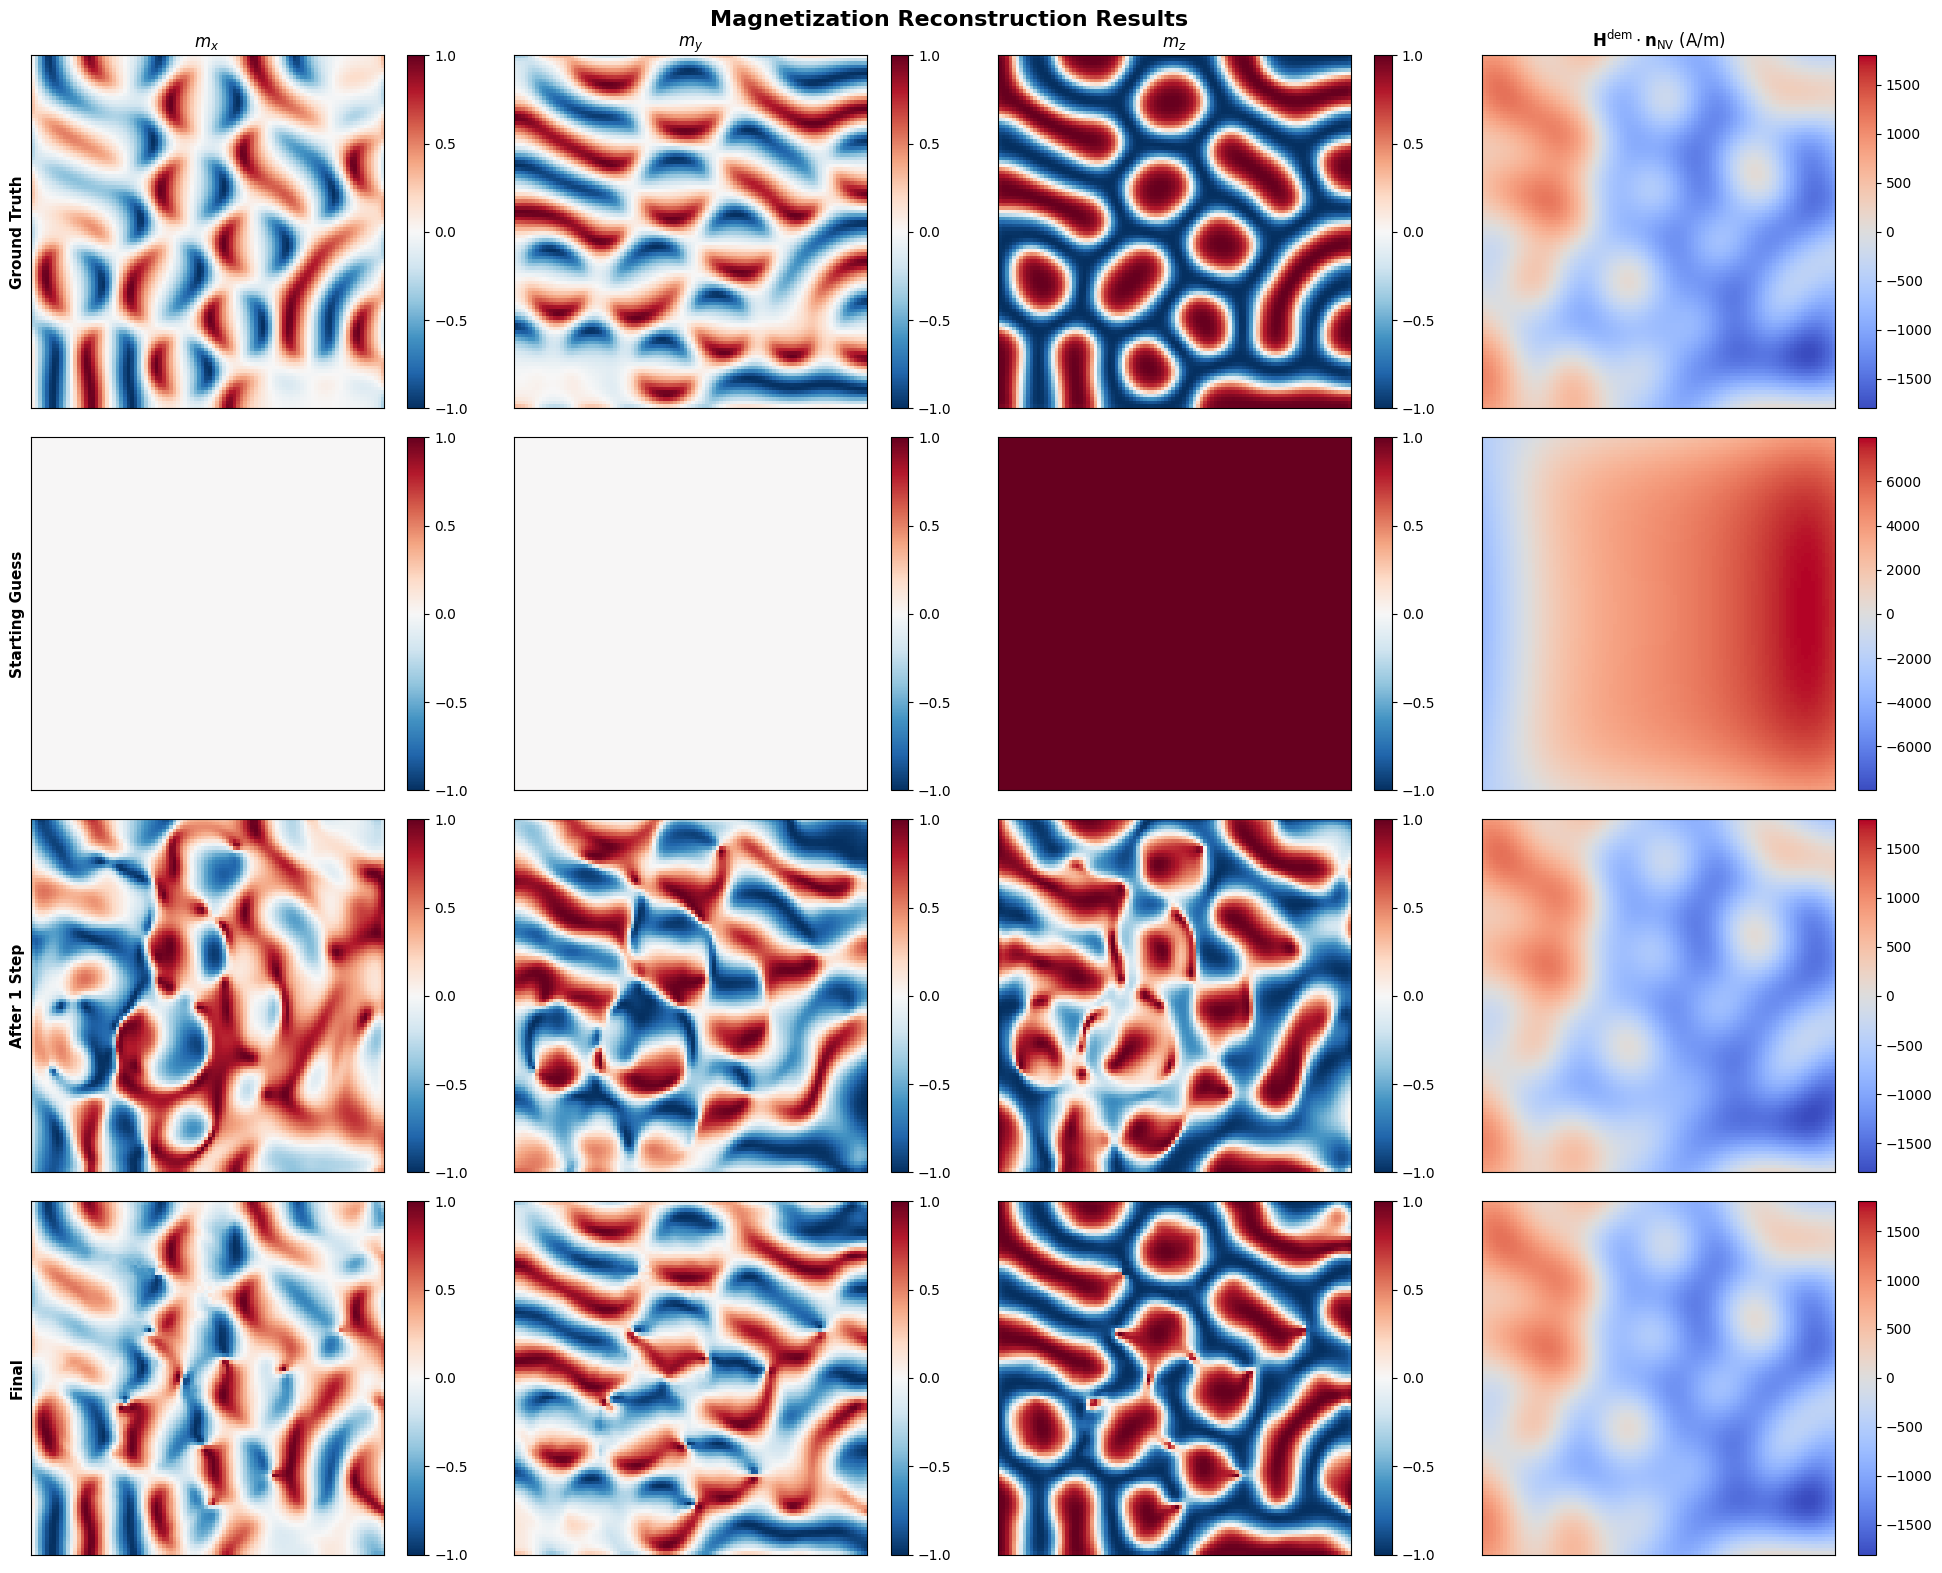

In [12]:
comp_labels = ["$m_x$", "$m_y$", "$m_z$", r"$\mathbf{H}^\mathrm{dem} \cdot \mathbf{n}_\mathrm{NV}$ (A/m)"]
row_labels = [
    "Ground Truth",
    "Starting Guess",
    "After 1 Step",
    "Final",
]
row_data = [m_true, m_0, m_rec_1, m_rec]
row_fields = [h_true, h_0, h_rec_1, h_rec]

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for row, (label, m, h) in enumerate(zip(row_labels, row_data, row_fields)):
    # Plot magnetization components
    for i in range(3):
        im = axes[row, i].imshow(m[:, :, 0, i].T, origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
        # Only show component labels in the top row
        if row == 0:
            axes[row, i].set_title(comp_labels[i], fontsize=12)
        # Add row labels on the left
        if i == 0:
            axes[row, i].set_ylabel(label, fontsize=11, fontweight='bold')
        axes[row, i].set_xticks([])
        axes[row, i].set_yticks([])
        cb = plt.colorbar(im, ax=axes[row, i], fraction=0.046)
        cb.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    
    # Plot H-field projection
    h_vlim = h.abs().max().item()
    im = axes[row, 3].imshow(h.T, origin="lower", cmap="coolwarm", vmin=-h_vlim, vmax=h_vlim)
    if row == 0:
        axes[row, 3].set_title(comp_labels[3], fontsize=12)
    axes[row, 3].set_xticks([])
    axes[row, 3].set_yticks([])
    plt.colorbar(im, ax=axes[row, 3], fraction=0.046)

fig.suptitle("Magnetization Reconstruction Results", fontsize=16, fontweight='bold')
fig.tight_layout()
fig.savefig("data/results.png", dpi=150)

### Pointwise Error

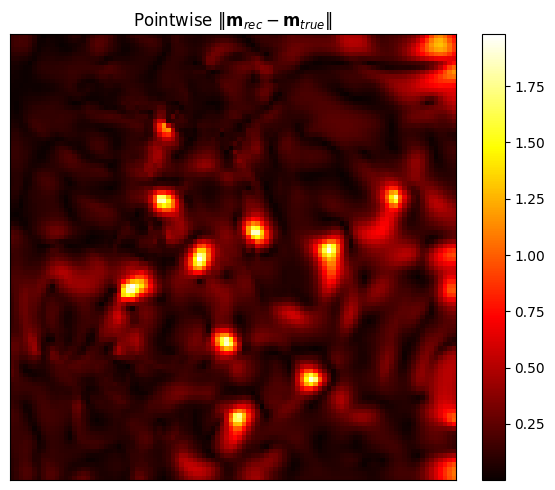

In [13]:
m_err = (m_rec - m_true).norm(dim=-1)[:, :, 0]
fig2, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(m_err.T, origin="lower", cmap="hot")
ax.set_title("Pointwise $\|\\mathbf{m}_{rec} - \\mathbf{m}_{true}\|$")
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im, ax=ax, fraction=0.046)
fig2.tight_layout()
fig2.savefig("data/error_map.png", dpi=150)